In [616]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
# Finance related operations
from pandas_datareader import data
# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error

# STEP 1: LOAD DATA

First things first, we need to load the data from the `.csv` file. This is easily done with `pandas`.

Furthermore, it is convenient to immediately drop those rows where *all* the values are `NaN`.

In [617]:
# Load data
Financial_df = pd.read_csv('2018_Financial_Data.csv')
#df = pd.read_csv('2018_Financial_Data.csv')
                   
# Drop rows with no information
Financial_df.dropna(how='all', inplace=True)

In [618]:
Financial_df =Financial_df.rename(columns={"Unnamed: 0": "Company Name"})

# STEP 2: FIRST LOOK AT THE DATASET

## STEP 2.1: general info, categorical variables

It is useful to take a quick look at the initial state of the dataset:

1. use `.info()`, `.describe()` method to get a first sense of the dimensions of the dataset and value of numeric variables;
2. focus on the categorical variables and also the class of the samples, to see if they are balanced.

In [619]:
# Get info about dataset
Financial_df.info()

# Describe dataset variables
Financial_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4392 entries, 0 to 4391
Columns: 225 entries, Company Name to Class
dtypes: float64(222), int64(1), object(2)
memory usage: 7.6+ MB


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2019 PRICE VAR [%],Class
count,4.346000e+03,4253.000000,4.207000e+03,4.328000e+03,4.155000e+03,4.226000e+03,4.208000e+03,4.357000e+03,4.208000e+03,4.321000e+03,...,4067.000000,4268.000000,4160.000000,4178.000000,4121.000000,4128.000000,4133.000000,4144.000000,4392.000000,4392.000000
mean,5.119287e+09,3.455278,3.144946e+09,2.043954e+09,1.180176e+08,9.005022e+08,1.435546e+09,6.541207e+08,1.001350e+08,5.584432e+08,...,0.006081,36.768524,0.183066,1.389013,0.262530,9.928446,0.091891,0.153610,20.803948,0.693534
std,2.049504e+10,195.504906,1.508813e+10,7.682369e+09,9.330891e+08,3.661116e+09,5.529831e+09,2.969341e+09,3.780021e+08,2.639327e+09,...,0.239653,2347.079237,4.688013,35.123904,5.612666,363.717734,0.823281,0.839647,82.622147,0.461078
min,-6.894100e+07,-3.461500,-2.669055e+09,-1.818220e+09,-1.042000e+08,-1.401594e+08,-4.280000e+09,-1.455700e+10,-1.408252e+09,-2.177200e+10,...,-1.000000,-1.000000,-1.000000,-0.999100,-32.258100,-1.000000,-1.000000,-1.000000,-99.864779,0.000000
25%,6.501425e+07,0.000000,3.415500e+06,3.618903e+07,0.000000e+00,2.056226e+07,4.223644e+07,-5.510000e+06,0.000000e+00,-1.000800e+07,...,0.000000,-0.048075,0.000000,-0.036700,-0.108600,-0.082850,0.000000,-0.004650,-7.477173,0.000000
50%,4.982640e+08,0.074900,1.741180e+08,2.219470e+08,0.000000e+00,9.390450e+07,1.806253e+08,4.203800e+07,5.693500e+06,2.730700e+07,...,0.000000,0.010200,0.000000,0.034750,0.026100,0.000000,0.000000,0.065700,17.639393,1.000000
75%,2.457878e+09,0.188500,1.297814e+09,9.767015e+08,1.450150e+07,4.117162e+08,6.796040e+08,2.862690e+08,5.817075e+07,2.238810e+08,...,0.042050,0.185900,0.080050,0.160575,0.138400,0.115425,0.009700,0.167625,39.625879,1.000000
max,5.003430e+11,12739.000000,3.733960e+11,1.269470e+11,2.883700e+10,1.065100e+11,1.065100e+11,7.089800e+10,9.168000e+09,7.290300e+10,...,4.079100,153332.333300,293.473000,1184.993800,313.395800,17646.823500,36.898100,43.718800,3756.716345,1.000000


In [620]:
Financial_df.head()

,Company Name,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1


In [621]:
Financial_df.shape

(4392, 225)

We now know that we have:

4392 samples

225 columns

222 numeric --> they are the financial indicators

1 int --> this is the class column

2 object --> this is categorical (Company Name,Sector)

## Detecting missing values

In [622]:
Total_Missing = Financial_df.isnull().sum().sort_values()
Percent_Missing = ((Financial_df.isnull().sum()*100)/(Financial_df.isnull().count())).sort_values()
Missing_data = pd.concat([Total_Missing, Percent_Missing], axis=1, keys=["Total", "Percent"])
Missing_data

,Total,Percent
Company Name,0,0.000000
Sector,0,0.000000
2019 PRICE VAR [%],0,0.000000
Class,0,0.000000
Financing Cash Flow,19,0.432605
...,...,...
dividendPayoutRatio,1658,37.750455
10Y Shareholders Equity Growth (per Share),1695,38.592896
shortTermCoverageRatios,1926,43.852459
operatingCycle,4386,99.863388


Dropping any rows with over 50% null values!

In [623]:
Financial_df=Financial_df.drop(columns=['cashConversionCycle','operatingCycle','operatingProfitMargin'])

## Dropping Features Using Correlation

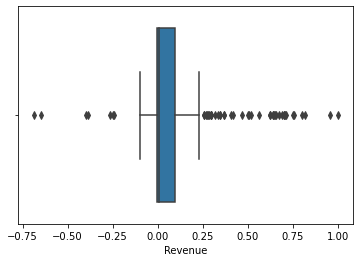

In [624]:
dfcor=Financial_df.corr()
sns.boxplot(dfcor['Revenue'])

In [625]:
dfcor= dfcor[:1]
dfcor.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2019 PRICE VAR [%],Class
Revenue,1.0,-0.003888,0.95378,0.814709,0.364756,0.701684,0.800147,0.640481,0.466732,0.65173,...,0.044995,-0.003803,-0.005479,-0.008657,-0.002757,-0.005846,-0.024754,-0.019629,0.005469,0.074664


In [626]:
for x in dfcor.columns:
    
    for y in dfcor[x]:  
            if y > 0.4:
                print(x)

Revenue
Cost of Revenue
Gross Profit
SG&A Expense
Operating Expenses
Operating Income
Interest Expense
Earnings before Tax
Income Tax Expense
Net Income - Non-Controlling int
Net Income
Net Income Com
EBITDA
EBIT
Consolidated Income
Property, Plant & Equipment Net
Goodwill and Intangible Assets
Total non-current assets
Payables
Tax Liabilities
Total non-current liabilities
Retained earnings (deficit)
Total shareholders equity
Depreciation & Amortization
Free Cash Flow
Enterprise Value


In [627]:
for x in dfcor.columns:
    
    for y in dfcor[x]:  
            if y > -0.4:
                break
            print(x)

Capital Expenditure
Investing Cash flow
Dividend payments


In [628]:
Financial_df.shape

(4392, 222)

In [629]:
# Defined a function to delete columns with the high correlation above 0.7 variables

def drop_highcorrelated_features(dataset, threshold=0.7):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f'Deleted {colname} from dataset.')
                    del dataset[colname]

    return dataset

In [630]:
drop_highcorrelated_features(Financial_df)

Deleted Cost of Revenue from dataset.
Deleted Gross Profit from dataset.
Deleted SG&A Expense from dataset.
Deleted Operating Expenses from dataset.
Deleted Earnings before Tax from dataset.
Deleted Income Tax Expense from dataset.
Deleted Net Income from dataset.
Deleted Net Income Com from dataset.
Deleted EPS Diluted from dataset.
Deleted Weighted Average Shs Out (Dil) from dataset.
Deleted Profit Margin from dataset.
Deleted Free Cash Flow margin from dataset.
Deleted EBITDA from dataset.
Deleted EBIT from dataset.
Deleted Consolidated Income from dataset.
Deleted Earnings Before Tax Margin from dataset.
Deleted Net Profit Margin from dataset.
Deleted Cash and short-term investments from dataset.
Deleted Total current assets from dataset.
Deleted Property, Plant & Equipment Net from dataset.
Deleted Total non-current assets from dataset.
Deleted Total assets from dataset.
Deleted Total current liabilities from dataset.
Deleted Total debt from dataset.
Deleted Tax Liabilities from d

,Company Name,Revenue,Revenue Growth,R&D Expenses,Operating Income,Interest Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Preferred Dividends,EPS,...,5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Inventory Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,1.900900e+10,3.542000e+09,131000000.0,0.000000e+00,0.0,2.56,...,0.1865,0.2348,0.0000,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,0.000000e+00,3.794000e+09,1.917000e+09,310000000.0,0.000000e+00,128000000.0,0.66,...,-0.1421,-0.2785,-0.0920,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,1.354300e+10,2.331600e+10,-1.260000e+08,0.0,0.000000e+00,0.0,4.57,...,0.0592,0.0772,0.0387,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,2.141000e+09,1.499400e+10,3.420000e+08,3000000.0,0.000000e+00,0.0,12.27,...,0.0000,0.0000,0.1511,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,0.000000e+00,-1.455700e+10,5.059000e+09,-178000000.0,1.726000e+09,894000000.0,-2.62,...,-0.1408,-0.2619,-0.2892,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,YRIV,0.000000e+00,0.0000,0.000000e+00,-3.755251e+06,1.105849e+07,0.0,0.000000e+00,0.0,-0.08,...,NaN,0.0000,0.0000,-0.1409,-0.0152,0.0000,-0.2602,Real Estate,-90.962099,0
4388,YTEN,5.560000e+05,-0.4110,4.759000e+06,-9.274000e+06,0.000000e+00,0.0,0.000000e+00,0.0,-0.92,...,0.0000,0.0000,0.0000,-0.8602,0.0000,0.0352,-0.0993,Basic Materials,-77.922077,0
4389,ZKIN,5.488438e+07,0.2210,1.652633e+06,9.617636e+06,1.239170e+06,84943.0,0.000000e+00,0.0,0.52,...,NaN,0.0000,0.7706,0.4074,-0.0968,0.2415,0.8987,Basic Materials,-17.834400,0
4390,ZOM,0.000000e+00,0.0000,1.031715e+07,-1.664863e+07,0.000000e+00,0.0,0.000000e+00,0.0,-0.18,...,NaN,NaN,0.0000,-0.2200,0.0000,2.7499,0.1457,Industrials,-73.520000,0


In [631]:
# Defined a function to delete columns with the insignificant correlation below 0.05 variables
def drop_minimalcorrelated_features(dataset, threshold=0.05):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] <= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f'Deleted {colname} from dataset.')
                    del dataset[colname]

    return dataset

In [632]:
drop_minimalcorrelated_features(Financial_df)

Deleted Revenue Growth from dataset.
Deleted Net Income - Non-Controlling int from dataset.
Deleted Net Income - Discontinued ops from dataset.
Deleted Preferred Dividends from dataset.
Deleted EPS from dataset.
Deleted Dividend per Share from dataset.
Deleted Gross Margin from dataset.
Deleted EBITDA Margin from dataset.
Deleted EBIT Margin from dataset.
Deleted Cash and cash equivalents from dataset.
Deleted Short-term investments from dataset.
Deleted Receivables from dataset.
Deleted Inventories from dataset.
Deleted Long-term investments from dataset.
Deleted Short-term debt from dataset.
Deleted Other comprehensive income from dataset.
Deleted Net Debt from dataset.
Deleted Other Assets from dataset.
Deleted Capital Expenditure from dataset.
Deleted Acquisitions and disposals from dataset.
Deleted Investment purchases and sales from dataset.
Deleted Investing Cash flow from dataset.
Deleted Issuance (repayment) of debt from dataset.
Deleted Issuance (buybacks) of shares from data

,Company Name,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow,Sector
0,CMCSA,9.450700e+10,0.000000e+00,1.900900e+10,3.542000e+09,4.549505e+09,1.676230e+11,0.000000e+00,8.494000e+09,1.073450e+11,2.182000e+09,4.198300e+10,2.429700e+10,Consumer Cyclical
1,KMI,1.414400e+10,0.000000e+00,3.794000e+09,1.917000e+09,2.207018e+09,2.484500e+10,1.566000e+09,1.337000e+09,3.393600e+10,0.000000e+00,-7.716000e+09,5.043000e+09,Energy
2,INTC,7.084800e+10,1.354300e+10,2.331600e+10,-1.260000e+08,4.564000e+09,3.634900e+10,0.000000e+00,3.824000e+09,2.509800e+10,0.000000e+00,5.017200e+10,2.943200e+10,Technology
3,MU,3.039100e+10,2.141000e+09,1.499400e+10,3.420000e+08,1.159811e+09,1.559000e+09,1.022000e+09,4.374000e+09,3.780000e+09,0.000000e+00,2.439500e+10,1.740000e+10,Technology
4,GE,1.216150e+11,0.000000e+00,-1.455700e+10,5.059000e+09,8.698115e+09,4.615200e+10,1.211700e+10,1.425700e+10,9.710900e+10,1.898300e+10,9.310900e+10,4.246000e+09,Industrials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,YRIV,0.000000e+00,0.000000e+00,-3.755251e+06,1.105849e+07,NaN,0.000000e+00,6.604801e+06,4.392118e+07,9.996396e+07,0.000000e+00,-5.495495e+07,-6.299496e+06,Real Estate
4388,YTEN,5.560000e+05,4.759000e+06,-9.274000e+06,0.000000e+00,1.002581e+07,0.000000e+00,0.000000e+00,1.170000e+05,5.621000e+06,0.000000e+00,-3.519380e+08,-8.754000e+06,Basic Materials
4389,ZKIN,5.488438e+07,1.652633e+06,9.617636e+06,1.239170e+06,1.306835e+07,9.382210e+05,2.995960e+05,5.364896e+06,0.000000e+00,0.000000e+00,1.713859e+07,-2.234995e+06,Basic Materials
4390,ZOM,0.000000e+00,1.031715e+07,-1.664863e+07,0.000000e+00,9.479621e+07,1.305800e+04,0.000000e+00,2.376519e+06,0.000000e+00,0.000000e+00,-3.227379e+07,-1.114753e+07,Industrials


In [633]:
Financial_df.shape

(4392, 14)

In [634]:
for col in Financial_df.columns: 
    print(col) 

Company Name
Revenue
R&D Expenses
Operating Income
Interest Expense
Weighted Average Shs Out
Goodwill and Intangible Assets
Tax assets
Payables
Long-term debt
Deferred revenue
Retained earnings (deficit)
Operating Cash Flow
Sector


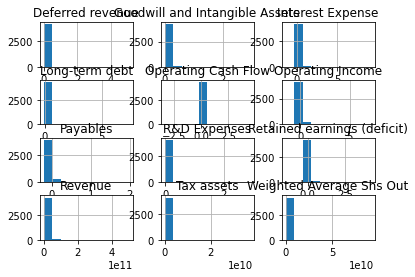

In [635]:

# Danceability is normally distributed
# There is a pretty even distribution of energy
# Popularity seems to be all over the place
# Instrumentalness, liveness, speechiness, 

Financial_df.hist()
plt.show()

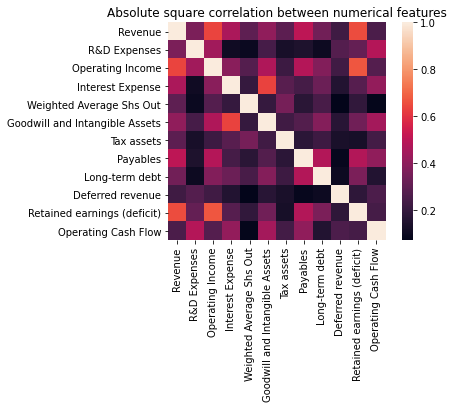

In [636]:
Financial_num = Financial_df.select_dtypes(include = np.number)
corr = np.abs(Financial_num.corr())
sns.heatmap(corr, square = True)
plt.title('Absolute square correlation between numerical features')
plt.show()

# STEP 6: FILL MISSING VALUES

We can now fill the missing values, but how? There are several methods we could use to fill the missing values:
* fill `nan` with 0
* fill `nan` with mean value of column
* fill `nan` with mode value of column
* fill `nan` with previous value
* ...
In this case, I think it is appropriate to fill the missing values with the mean value of the column.

In [637]:
import missingno as msno

### Visualize missing values
**Matrix :**
Using this matrix you can very quickly find the pattern of missingness in the dataset. In our example, the columns AAWhiteSt-4 and SulphidityL-4 have a similar pattern

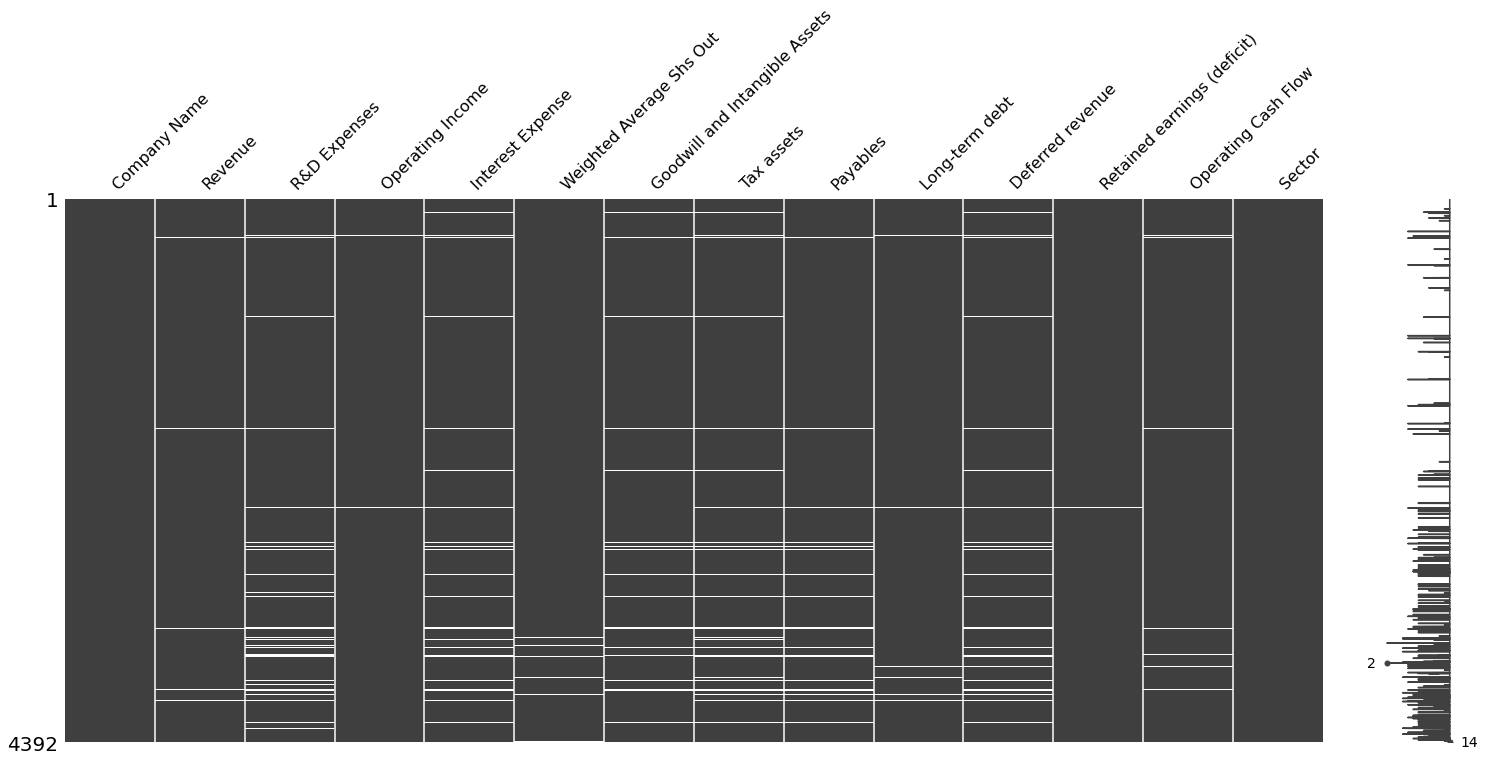

In [638]:
# Visualize missing values as a matrix 
msno.matrix(Financial_df)

**Heatmap :**
Heatmap shows the correlation of missingness between every 2 columns.

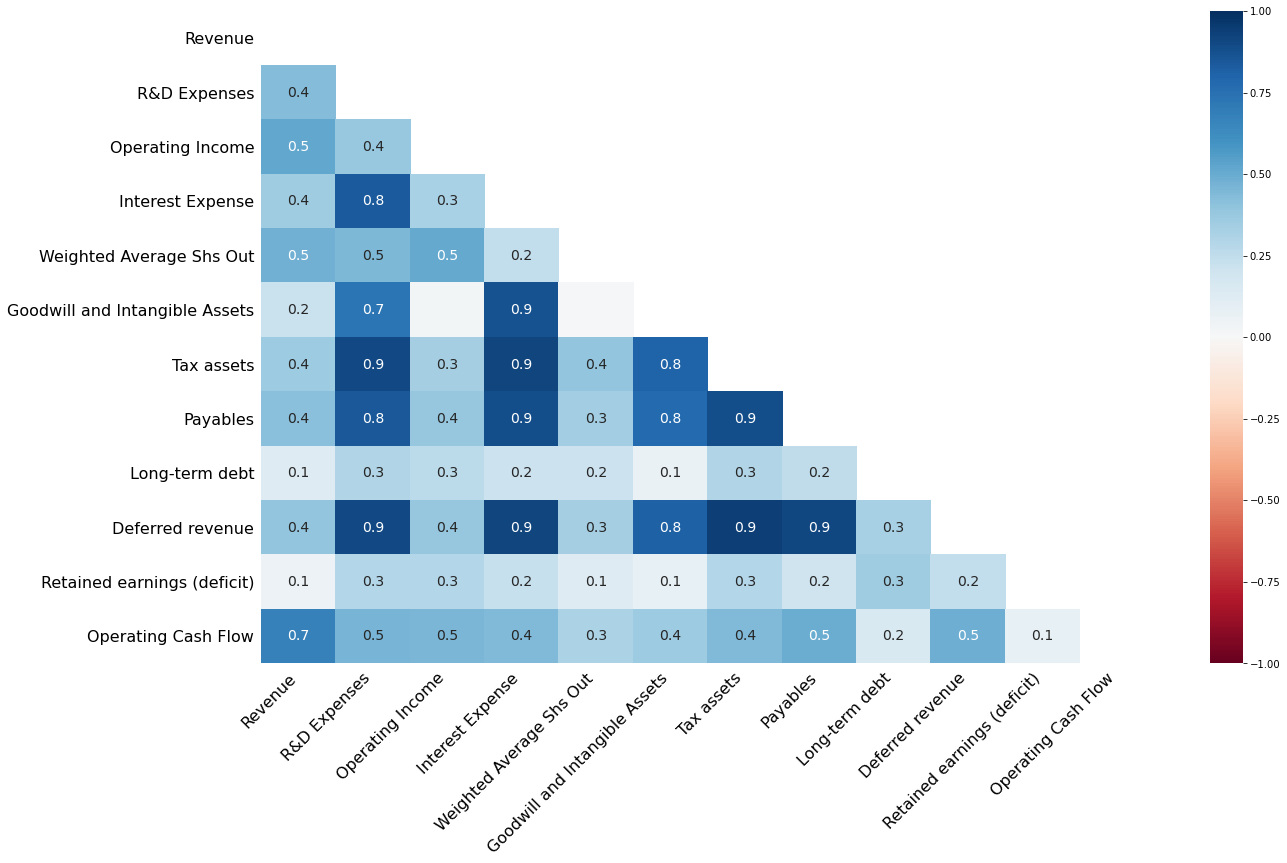

In [639]:
msno.heatmap(Financial_df)

**Bar Chart :**
This bar chart gives you an idea about how many missing values are there in each column. 

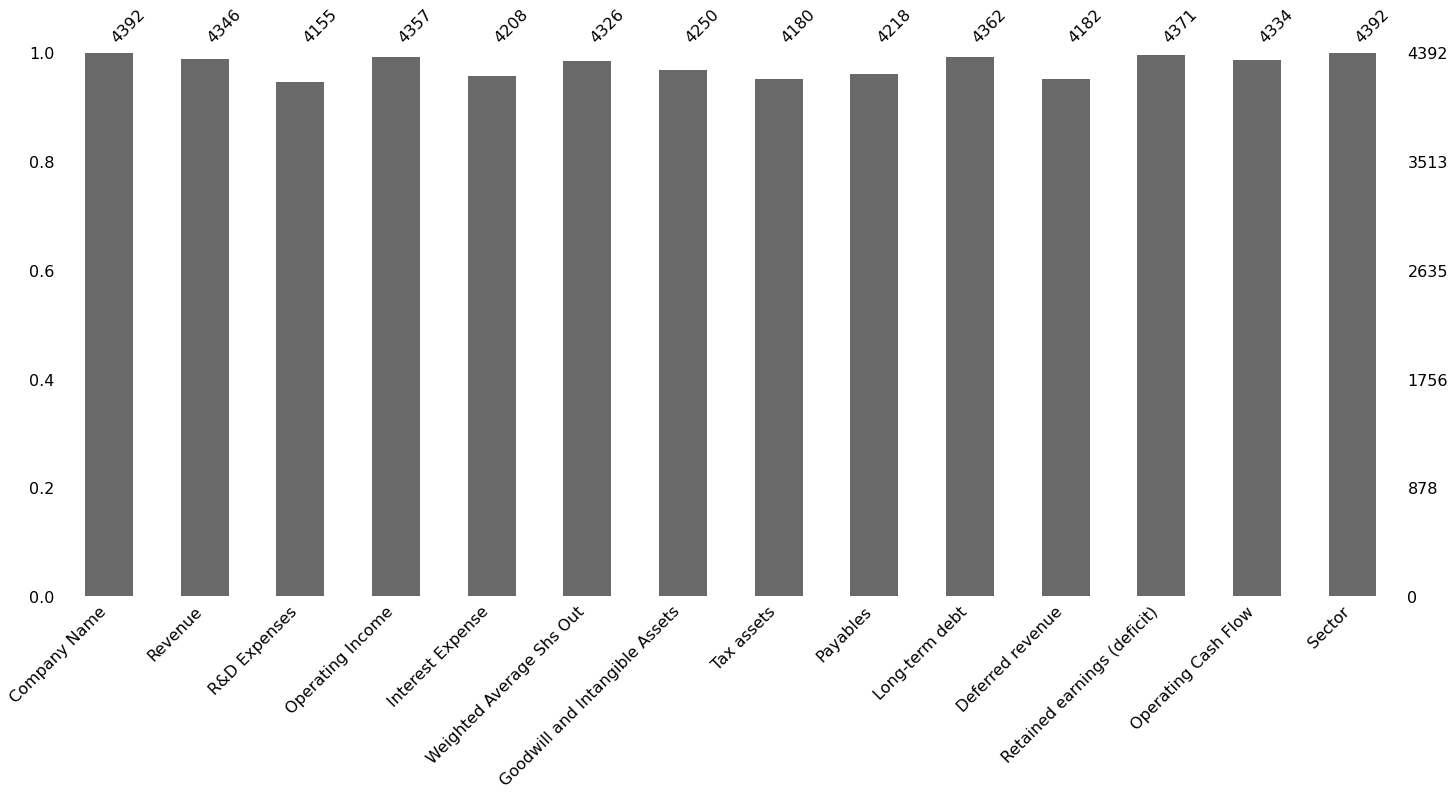

In [640]:
msno.bar(Financial_df)

In [641]:
data_info=pd.DataFrame(Financial_df.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(Financial_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_info=data_info.append(pd.DataFrame(Financial_df.isnull().sum()/Financial_df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(data_info)

,Company Name,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow,Sector
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
null values (nb),0,46,237,35,184,66,142,212,174,30,210,21,58,0
null values (%),0,1.04736,5.39617,0.796903,4.18944,1.50273,3.23315,4.82696,3.96175,0.68306,4.78142,0.478142,1.32058,0


In [642]:
Financial_df.head()

,Company Name,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow,Sector
0,CMCSA,9.450700e+10,0.000000e+00,1.900900e+10,3.542000e+09,4.549505e+09,1.676230e+11,0.000000e+00,8.494000e+09,1.073450e+11,2.182000e+09,4.198300e+10,2.429700e+10,Consumer Cyclical
1,KMI,1.414400e+10,0.000000e+00,3.794000e+09,1.917000e+09,2.207018e+09,2.484500e+10,1.566000e+09,1.337000e+09,3.393600e+10,0.000000e+00,-7.716000e+09,5.043000e+09,Energy
2,INTC,7.084800e+10,1.354300e+10,2.331600e+10,-1.260000e+08,4.564000e+09,3.634900e+10,0.000000e+00,3.824000e+09,2.509800e+10,0.000000e+00,5.017200e+10,2.943200e+10,Technology
3,MU,3.039100e+10,2.141000e+09,1.499400e+10,3.420000e+08,1.159811e+09,1.559000e+09,1.022000e+09,4.374000e+09,3.780000e+09,0.000000e+00,2.439500e+10,1.740000e+10,Technology
4,GE,1.216150e+11,0.000000e+00,-1.455700e+10,5.059000e+09,8.698115e+09,4.615200e+10,1.211700e+10,1.425700e+10,9.710900e+10,1.898300e+10,9.310900e+10,4.246000e+09,Industrials


From a practical perspective, this translates into **filling the missing value with the mean value of the column, grouped by each sector**.

In [643]:
# Replace nan-values with mean value of column, considering each sector individually.
#Financial_df = Financial_df.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))

Financial_df=Financial_df.fillna(Financial_df.mean())


In [644]:
data_info=pd.DataFrame(Financial_df.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(Financial_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
data_info=data_info.append(pd.DataFrame(Financial_df.isnull().sum()/Financial_df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(data_info)

,Company Name,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow,Sector
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [645]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(Financial_df, title="Pandas Profiling Report",correlations=None, interactions=None)
#Profile
Financial_df.head()

,Company Name,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow,Sector
0,CMCSA,9.450700e+10,0.000000e+00,1.900900e+10,3.542000e+09,4.549505e+09,1.676230e+11,0.000000e+00,8.494000e+09,1.073450e+11,2.182000e+09,4.198300e+10,2.429700e+10,Consumer Cyclical
1,KMI,1.414400e+10,0.000000e+00,3.794000e+09,1.917000e+09,2.207018e+09,2.484500e+10,1.566000e+09,1.337000e+09,3.393600e+10,0.000000e+00,-7.716000e+09,5.043000e+09,Energy
2,INTC,7.084800e+10,1.354300e+10,2.331600e+10,-1.260000e+08,4.564000e+09,3.634900e+10,0.000000e+00,3.824000e+09,2.509800e+10,0.000000e+00,5.017200e+10,2.943200e+10,Technology
3,MU,3.039100e+10,2.141000e+09,1.499400e+10,3.420000e+08,1.159811e+09,1.559000e+09,1.022000e+09,4.374000e+09,3.780000e+09,0.000000e+00,2.439500e+10,1.740000e+10,Technology
4,GE,1.216150e+11,0.000000e+00,-1.455700e+10,5.059000e+09,8.698115e+09,4.615200e+10,1.211700e+10,1.425700e+10,9.710900e+10,1.898300e+10,9.310900e+10,4.246000e+09,Industrials


## Data Exploration

In [646]:
# Get univariate statistics to 
# summarize the central tendency, dispersion, 
# and shape of a dataset’s distribution

Financial_df.describe()


,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow
count,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03,4.392000e+03
mean,5.119287e+09,1.180176e+08,6.541207e+08,1.001350e+08,2.668513e+08,1.932813e+09,1.353120e+08,8.739519e+08,3.531433e+09,1.431115e+08,2.210158e+09,9.263815e+08
std,2.038741e+10,9.075586e+08,2.957483e+09,3.699974e+08,2.010219e+09,9.282323e+09,1.016593e+09,6.019815e+09,2.069655e+10,1.250293e+09,1.298870e+10,1.014208e+10
min,-6.894100e+07,-1.042000e+08,-1.455700e+10,-1.408252e+09,1.190000e+02,0.000000e+00,0.000000e+00,-2.015203e+10,-7.150761e+09,0.000000e+00,-1.488075e+11,-3.400000e+11
25%,6.584545e+07,0.000000e+00,-5.199308e+06,0.000000e+00,1.988308e+07,1.139362e+04,0.000000e+00,3.707649e+06,2.233000e+06,0.000000e+00,-1.497984e+08,1.022500e+06
50%,5.200504e+08,0.000000e+00,4.366150e+07,7.534500e+06,4.834789e+07,5.990750e+07,0.000000e+00,3.591100e+07,1.999770e+08,0.000000e+00,2.451395e+07,6.967420e+07
75%,2.582760e+09,2.787450e+07,3.019341e+08,7.798475e+07,1.333327e+08,7.662405e+08,1.808125e+07,2.664878e+08,1.481750e+09,9.207000e+06,6.287849e+08,4.011135e+08
max,5.003430e+11,2.883700e+10,7.089800e+10,9.168000e+09,9.133623e+10,2.931280e+11,3.668898e+10,1.967100e+11,7.330000e+11,5.067600e+10,4.216530e+11,4.470000e+11


<ipython-input-647-61b7cecaed37>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  Financial_df.hist(ax=ax)


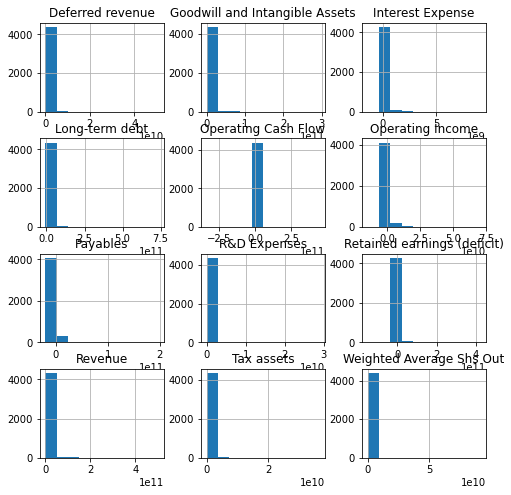

In [647]:
# Univariate visualization of the continuous variables 
# to get a sense of their distribution
# Plot Histograms 
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
Financial_df.hist(ax=ax)
plt.show()


The histograms illustrate highly skewed distributions for each feature.

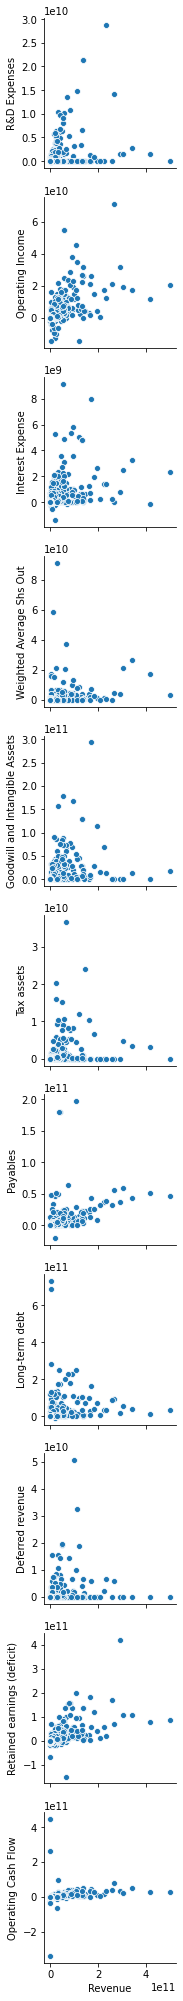

In [648]:
# Multivariate analysis

# Bivariate analysis of two continuous variables

# Plot scatter plots to look at the relationship between the target variable 
# and the continuous variables (if the first variable's value usually goes up 
# when the second one goes up, then this indicates a positive relationship.)

sns.pairplot(data=Financial_df,
                  x_vars=["Revenue"],
                  y_vars=["R&D Expenses","Operating Income", "Interest Expense","Weighted Average Shs Out","Goodwill and Intangible Assets",
                          "Tax assets","Payables","Long-term debt","Deferred revenue","Retained earnings (deficit)","Operating Cash Flow"])

In [649]:
# Apply the correlation coefficient to the continuous variables

# Get correlation matrix

Financial_df.corr()

,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow
Revenue,1.000000,0.360698,0.637369,0.464188,0.292779,0.406514,0.292486,0.503497,0.286636,0.226083,0.650294,0.256307
R&D Expenses,0.360698,1.000000,0.434980,0.106925,0.098306,0.237770,0.129555,0.145255,0.085279,0.276455,0.309545,0.184122
Operating Income,0.637369,0.434980,1.000000,0.387339,0.275615,0.469294,0.215891,0.481031,0.374972,0.227917,0.672695,0.276426
Interest Expense,0.464188,0.106925,0.387339,1.000000,0.199039,0.634073,0.279980,0.242093,0.270174,0.156603,0.276980,0.157729
Weighted Average Shs Out,0.292779,0.098306,0.275615,0.199039,1.000000,0.196475,0.347560,0.172552,0.244828,0.071179,0.194188,0.081808
Goodwill and Intangible Assets,0.406514,0.237770,0.469294,0.634073,0.196475,1.000000,0.225085,0.272825,0.320212,0.171243,0.335787,0.171796
Tax assets,0.292486,0.129555,0.215891,0.279980,0.347560,0.225085,1.000000,0.178721,0.184599,0.135696,0.127708,0.088851
Payables,0.503497,0.145255,0.481031,0.242093,0.172552,0.272825,0.178721,1.000000,0.396245,0.089265,0.478562,0.156290
Long-term debt,0.286636,0.085279,0.374972,0.270174,0.244828,0.320212,0.184599,0.396245,1.000000,0.085682,0.362908,0.130129
Deferred revenue,0.226083,0.276455,0.227917,0.156603,0.071179,0.171243,0.135696,0.089265,0.085682,1.000000,0.184670,0.098691


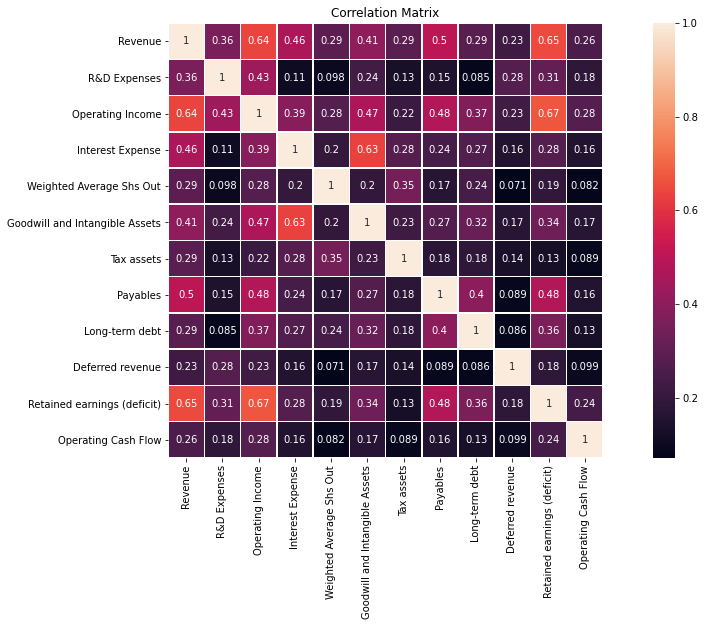

In [650]:
# Draw heat map to look at the correlations between continuous variables

corrmat_df = Financial_df.corr()

import seaborn as sns

plt.figure(figsize=(18,8))

sns.heatmap(corrmat_df, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [651]:
### Bivariate analysis of a continuous-categorical pair

# Look at the relationship between the target variable
# and the categorical variables

# Derive averages by group

R= Financial_df["Revenue"].describe()

print(R)

#print(df.age.value_counts())

#Financial_df.groupby("Revenue").describe()

count    4.392000e+03
mean     5.119287e+09
std      2.038741e+10
min     -6.894100e+07
25%      6.584545e+07
50%      5.200504e+08
75%      2.582760e+09
max      5.003430e+11
Name: Revenue, dtype: float64


In [653]:
def spgrouping(column):
    spgroup = []
    print(column.shape)
    for c in column:
      if (-68941001 < c and c < 65845450):
        #print('c1')
        spgroup.append('R1')
      elif (65845450< c and c < 520050400):
        #print('c2')
        spgroup.append('R2')
      elif (520050400< c and c <2579298000):
        #print('c3')
        spgroup.append('R3')
      elif (2579298000< c and c <500343000001):
        #print('c4')
        spgroup.append('R4') 
      #break     
    return spgroup
Financial_df['Revenuegroup'] = spgrouping(Financial_df.Revenue)
df =Financial_df 
df.info()

(4392,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4392 entries, 0 to 4391
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Company Name                    4392 non-null   object 
 1   Revenue                         4392 non-null   float64
 2   R&D Expenses                    4392 non-null   float64
 3   Operating Income                4392 non-null   float64
 4   Interest Expense                4392 non-null   float64
 5   Weighted Average Shs Out        4392 non-null   float64
 6   Goodwill and Intangible Assets  4392 non-null   float64
 7   Tax assets                      4392 non-null   float64
 8   Payables                        4392 non-null   float64
 9   Long-term debt                  4392 non-null   float64
 10  Deferred revenue                4392 non-null   float64
 11  Retained earnings (deficit)     4392 non-null   float64
 12  Operating Cash Flow       

In [573]:
# One-hot encoding

Financial_df = pd.concat([Financial_df, pd.get_dummies(Financial_df["Revenuegroup"])], axis=1)

Financial_df.head()

,Company Name,Revenue,R&D Expenses,Operating Income,Interest Expense,Weighted Average Shs Out,Goodwill and Intangible Assets,Tax assets,Payables,Long-term debt,Deferred revenue,Retained earnings (deficit),Operating Cash Flow,Sector,Revenuegroup,R1,R2,R3,R4
0,CMCSA,9.450700e+10,0.000000e+00,1.900900e+10,3.542000e+09,4.549505e+09,1.676230e+11,0.000000e+00,8.494000e+09,1.073450e+11,2.182000e+09,4.198300e+10,2.429700e+10,Consumer Cyclical,R4,0,0,0,1
1,KMI,1.414400e+10,0.000000e+00,3.794000e+09,1.917000e+09,2.207018e+09,2.484500e+10,1.566000e+09,1.337000e+09,3.393600e+10,0.000000e+00,-7.716000e+09,5.043000e+09,Energy,R4,0,0,0,1
2,INTC,7.084800e+10,1.354300e+10,2.331600e+10,-1.260000e+08,4.564000e+09,3.634900e+10,0.000000e+00,3.824000e+09,2.509800e+10,0.000000e+00,5.017200e+10,2.943200e+10,Technology,R4,0,0,0,1
3,MU,3.039100e+10,2.141000e+09,1.499400e+10,3.420000e+08,1.159811e+09,1.559000e+09,1.022000e+09,4.374000e+09,3.780000e+09,0.000000e+00,2.439500e+10,1.740000e+10,Technology,R4,0,0,0,1
4,GE,1.216150e+11,0.000000e+00,-1.455700e+10,5.059000e+09,8.698115e+09,4.615200e+10,1.211700e+10,1.425700e+10,9.710900e+10,1.898300e+10,9.310900e+10,4.246000e+09,Industrials,R4,0,0,0,1


## Modelling

In [575]:
# Y is the target variable

Y = Financial_df["Revenue"]

# X is the feature set


X = Financial_df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup","Long-term debt",
                      "Tax assets"], 1)


In [577]:
import statsmodels.api as sm

# You need to manually add a constant
# in statsmodels' sm

X = sm.add_constant(X)

# Fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# Print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     633.3
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:05:15   Log-Likelihood:            -1.0880e+05
No. Observations:                4392   AIC:                         2.176e+05
Df Residuals:                    4383   BIC:                         2.177e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.044e+09   1.77e+08      5.897      0.000    6.97e+08    1.39e+09
R&D Expenses            2.9503      0.259     11.382      0.000       2.442       3.459
Operating Income        2.2264      0.097     23.062      0.000       2.037       2.416
Interest Expense       11.8642      0.640     18.546      0.000      10.610      13.118
Payables                0.8196      0.040     20.481      0.000       0.741       0.898
Operating Cash Flow     0.1125      0.022      5.202      0.000       0.070       0.155
R1                  -1.267e+09   3.69e+08     -3.431      0.001   -1.99e+09   -5.43e+08
R2                  -1.152e+09   3.69e+08     -3.124      0.002   -1.88e+09   -4.29e+08
R3                  -1.008e+09   3.67e+08     -2.747      0.006   -1.73e+09   -2.89e+08
R4                   4.472e+09    4.1e+08     10.909      0.000    3.67e+09    5.28e+09
==============================================================================
Omnibus:                     7362.865   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12839278.080
Skew:                          10.933   Prob(JB):                         0.00
Kurtosis:                     266.973   Cond. No.                     9.31e+25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.39e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

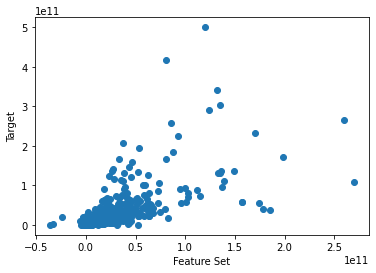

In [578]:
# Predictions of the regression

predictions = results.predict()

# Plot the estimated `Y` and `X`
plt.scatter(predictions, Y)
plt.xlabel("Feature Set")
plt.ylabel("Target")
plt.show()


##  Model 1: Linear Regression

In [580]:
# Y is the target variable (what you are trying to predict)

Y = Financial_df["Revenue"]

# X is the feature set that you are using to predict Approved_Conversion
# ["R&D Expenses","Operating Income", "Interest Expense","Long-term debt","Operating Cash Flow","operatingProfitMargin","Payables","Tax assets"]

#X = Financial_df.drop(columns = ['Revenue',"Company Name","Sector","Revenuegroup"])

X = Financial_df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup","Long-term debt",
                      "Tax assets"], 1)

# Split the data into training and test sets
# (the test_size parameter is set to 0.1, which 
# means that you'll use 10% of the data as the test set.)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 3)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3952
The number of observations in test set is 440


In [582]:
# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
Linear_model = LinearRegression()

# Fit method estimates the coefficients
LRM=Linear_model.fit(X_train, y_train)


# Inspect the results
print('\nCoefficients: \n', LRM.coef_)
print('\nIntercept: \n', LRM.intercept_)


Coefficients: 
 [ 3.01475051e+00  1.92210767e+00  1.19833680e+01  1.08922244e+00
  1.98324254e-01 -1.46424350e+09 -1.38718469e+09 -1.20072590e+09
  4.05215408e+09]

Intercept: 
 1271235313.28087


In [583]:
from sklearn.metrics import r2_score
# A simple regression test yielded very poor accuracy, with a relatively
# high root mean squared error

LR_pred = Linear_model.predict(X_test)
LR_y_pred_train = Linear_model.predict(X_train)


print('R-squared score of test set: ', r2_score(y_test, LR_pred))
print('R-squared score of training set: ', r2_score(y_train, LR_y_pred_train))
print('Root mean squared of test set: ', np.sqrt(mse(y_test, LR_pred)))
print('Root mean squared of training set: ', np.sqrt(mse(y_train, LR_y_pred_train)))


R-squared score of test set:  0.5141844713922562
R-squared score of training set:  0.5305466728679824
Root mean squared of test set:  12018725434.431017
Root mean squared of training set:  14186583488.938942


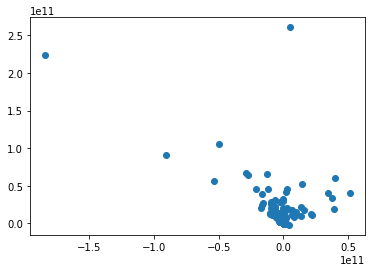

In [584]:

Linear_model_residual = y_test - LR_pred

plt.scatter(Linear_model_residual, LR_pred)

In [585]:
from sklearn.linear_model import LinearRegression, Lasso

In [586]:
# lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_y_pred = lasso.predict(X_test)

/Users/vahida/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.976256327574703e+23, tolerance: 1.6942603644144868e+20
  model = cd_fast.enet_coordinate_descent(


In [587]:
print(r2_score(y_test, lasso_y_pred))
print(np.sqrt(mse(y_test, lasso_y_pred)))


0.5141844713754264
12018725434.639194


In [588]:
# `X` is the feature set
# `Y` is the target variable
y = Financial_df["Revenue"]

X = Financial_df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup","Long-term debt",
                      "Tax assets"], 1)
# Add a constant to the model because it's best practice
# to do so every time!
X = sm.add_constant(X)

# Fit an OLS model using statsmodels
results = sm.OLS(y, X).fit()

# Print the summary results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     633.3
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:05:15   Log-Likelihood:            -1.0880e+05
No. Observations:                4392   AIC:                         2.176e+05
Df Residuals:                    4383   BIC:                         2.177e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.044e+09   1

In [590]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing

In [591]:
# `X` is the feature set
# `Y` is the target variable
y = Financial_df["Revenue"]

X = Financial_df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup"], 1)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 3)

# normalised_df = (Financial_df - Financial_df.mean()) / Financial_df.std()

X_train.tail()

# # temp = Financial_df.values
# # mean_max_scatter = preprocessing.MeanMaxScatter()
# # temp_scaled = mean_max_scatter

,R&D Expenses,Operating Income,Interest Expense,Payables,Operating Cash Flow,R1,R2,R3,R4
789,1.602600e+08,-137928000.0,1.988200e+07,1.682000e+07,78620000.0,0,0,1,0
968,0.000000e+00,422686000.0,0.000000e+00,0.000000e+00,505244000.0,0,0,1,0
1667,0.000000e+00,646200000.0,1.285000e+08,8.898000e+08,644200000.0,0,0,0,1
3321,1.180176e+08,-567000.0,1.001350e+08,8.739519e+08,-34000000.0,1,0,0,0
1688,0.000000e+00,100983000.0,2.343300e+07,5.953200e+07,136774000.0,0,1,0,0


In [592]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 3)

normalised_df = (X  - X.mean()) / X.std()
normalised_y = (Y  - Y.mean()) / Y.std()

X_train, X_test, y_train, y_test = train_test_split(normalised_df, normalised_y, test_size = 0.2,random_state = 1)

normalised_df.tail()

# temp = Financial_df.values
# mean_max_scatter = preprocessing.MeanMaxScatter()
# temp_scaled = mean_max_scatter

,R&D Expenses,Operating Income,Interest Expense,Tax assets,Payables,Long-term debt,Operating Cash Flow,R1,R2,R3,R4
4387,-0.130039,-0.222445,-0.240749,-0.126607,-0.137883,-0.165799,-0.091961,1.731854,-0.577285,-0.576934,-0.577635
4388,-0.124795,-0.224311,-0.270637,-0.133104,-0.145160,-0.170357,-0.092204,1.731854,-0.577285,-0.576934,-0.577635
4389,-0.128218,-0.217923,-0.267288,-0.132809,-0.144288,-0.170629,-0.091561,1.731854,-0.577285,-0.576934,-0.577635
4390,-0.118671,-0.226804,-0.270637,-0.133104,-0.144784,-0.170629,-0.092440,1.731854,-0.577285,-0.576934,-0.577635
4391,-0.067581,-0.232376,-0.270188,-0.133021,-0.142953,-0.170629,-0.088957,1.731854,-0.577285,-0.576934,-0.577635


In [593]:
# KNN 
# Finding the best K value:

k_value = range(1, 61, 2)
test_rmse= []
train_rmse = []
accuracy = []
train_accuracy= []

for i in k_value:
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_train_rmse = np.sqrt(mse(y_train, y_train_pred))
    y_test_pred = knn.predict(X_test)
    y_test_rmse = np.sqrt(mse(y_test, y_test_pred))
    test_rmse.append(y_test_rmse)
    train_rmse.append(y_train_rmse)
    accuracy.append(knn.score(X_test, y_test))
    train_accuracy.append(knn.score(X_train, y_train))
    

In [594]:
knn = KNeighborsRegressor(n_neighbors = 2)
knn.fit(X_train, y_train)
test_prediction = knn.predict(X_test)
#print(y_test_pred)
print(np.sqrt(mse(y_test,test_prediction,axis=0)))

0.7305762173360175


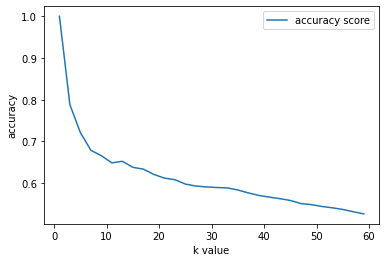

In [595]:
plt.plot(k_value, train_accuracy, label = 'accuracy score')
plt.legend()
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.show()

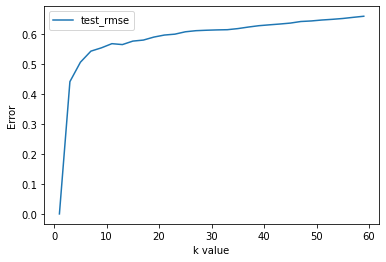

In [596]:
plt.plot(k_value,train_rmse, label = 'test_rmse')
plt.legend()
plt.xlabel('k value')
plt.ylabel('Error')
plt.show()

##  Model 2: Random Forest Regression

In [597]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score


In [598]:
# Y is the target variable (what you are trying to predict)

Y = Financial_df["Revenue"]

# X is the feature set that you are using to predict Approved_Conversion
# ["R&D Expenses","Operating Income", "Interest Expense","Long-term debt","Operating Cash Flow","operatingProfitMargin","Payables","Tax assets"]

X = Financial_df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup","Long-term debt",
                      "Tax assets"], 1)

# Split the data into training and test sets
# (the test_size parameter is set to 0.1, which 
# means that you'll use 10% of the data as the test set.)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 3513
The number of observations in test set is 879


In [599]:
X_train.head()

,R&D Expenses,Operating Income,Interest Expense,Payables,Operating Cash Flow,R1,R2,R3,R4
120,0.0,3.484920e+08,57904000.0,6.950400e+07,5.378040e+08,0,0,1,0
3352,0.0,1.614800e+07,282000.0,2.936800e+07,6.511000e+06,0,1,0,0
2333,0.0,4.276760e+08,576700000.0,9.533690e+08,5.845490e+08,0,0,1,0
403,0.0,7.274000e+09,668000000.0,2.402000e+09,3.138000e+09,0,0,0,1
4259,0.0,1.187900e+07,0.0,0.000000e+00,4.226500e+07,1,0,0,0


In [600]:
# Train the model

from sklearn.ensemble import RandomForestRegressor
#n_estimators=250, criterion="mse", max_depth=6, max_features=2
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

RandomForestRegressor()

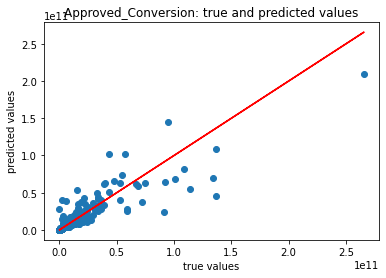

Mean absolute error of the prediction is: 2057744918.793334
Mean squared error of the prediction is: 5.816239443467369e+19
Root mean squared error of the prediction is: 7626427370.313946


In [601]:
# Make predictions by calling the predict() function

y_preds = RFR.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Approved_Conversion: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))

In [602]:
# Calculate R-squared

from sklearn.metrics import r2_score

print('R-squared score of test set: ', r2_score(y_test, y_preds))

R-squared score of test set:  0.795137005322371


In [603]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = Financial_df.drop('Revenuegroup', 1)
Y = Financial_df['Revenuegroup']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [604]:
from sklearn import tree

In [605]:
# Define outcome and predictors
y = Financial_df["Revenue"]
X = Financial_df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup","Long-term debt",
                      "Tax assets"], 1)


Weak learner 0 R^2: -2.017810747003405
Weak learner 20 R^2: -0.018655524269844737
Weak learner 40 R^2: -0.024146080985501417
Weak learner 60 R^2: -0.013345935639234474
Weak learner 80 R^2: -0.026052536508854862
Weak learner 100 R^2: -0.007127490439782003


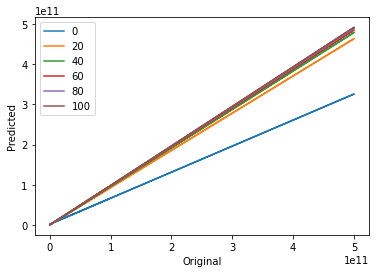

Overall R^2:
0.9940147637179528


In [606]:

# # Define outcome and predictors
# y = Financial_df['Operating Income']
# X = Financial_df.loc[:, ~Financial_df.columns.isin(['Operating Income', 'Revenuegroup'])]
# Print(X)
# Make the categorical variable `country` into dummies
X = pd.concat([X, pd.get_dummies(Financial_df['Revenuegroup'])], axis=1)

# Store values from loops
preds = pd.DataFrame()
labels = []

uniquex = Financial_df['Revenue'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs
for m in range(0, 101):
    
    # Initialize and fit the tree, and set the max depth to 2
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals
    y = y - pred

    # Output every 20 iterations
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(Financial_df['Revenue'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(Financial_df['Revenue'], predicted)[0, 1])

One strongish learner R^2: 0.5303754584922729


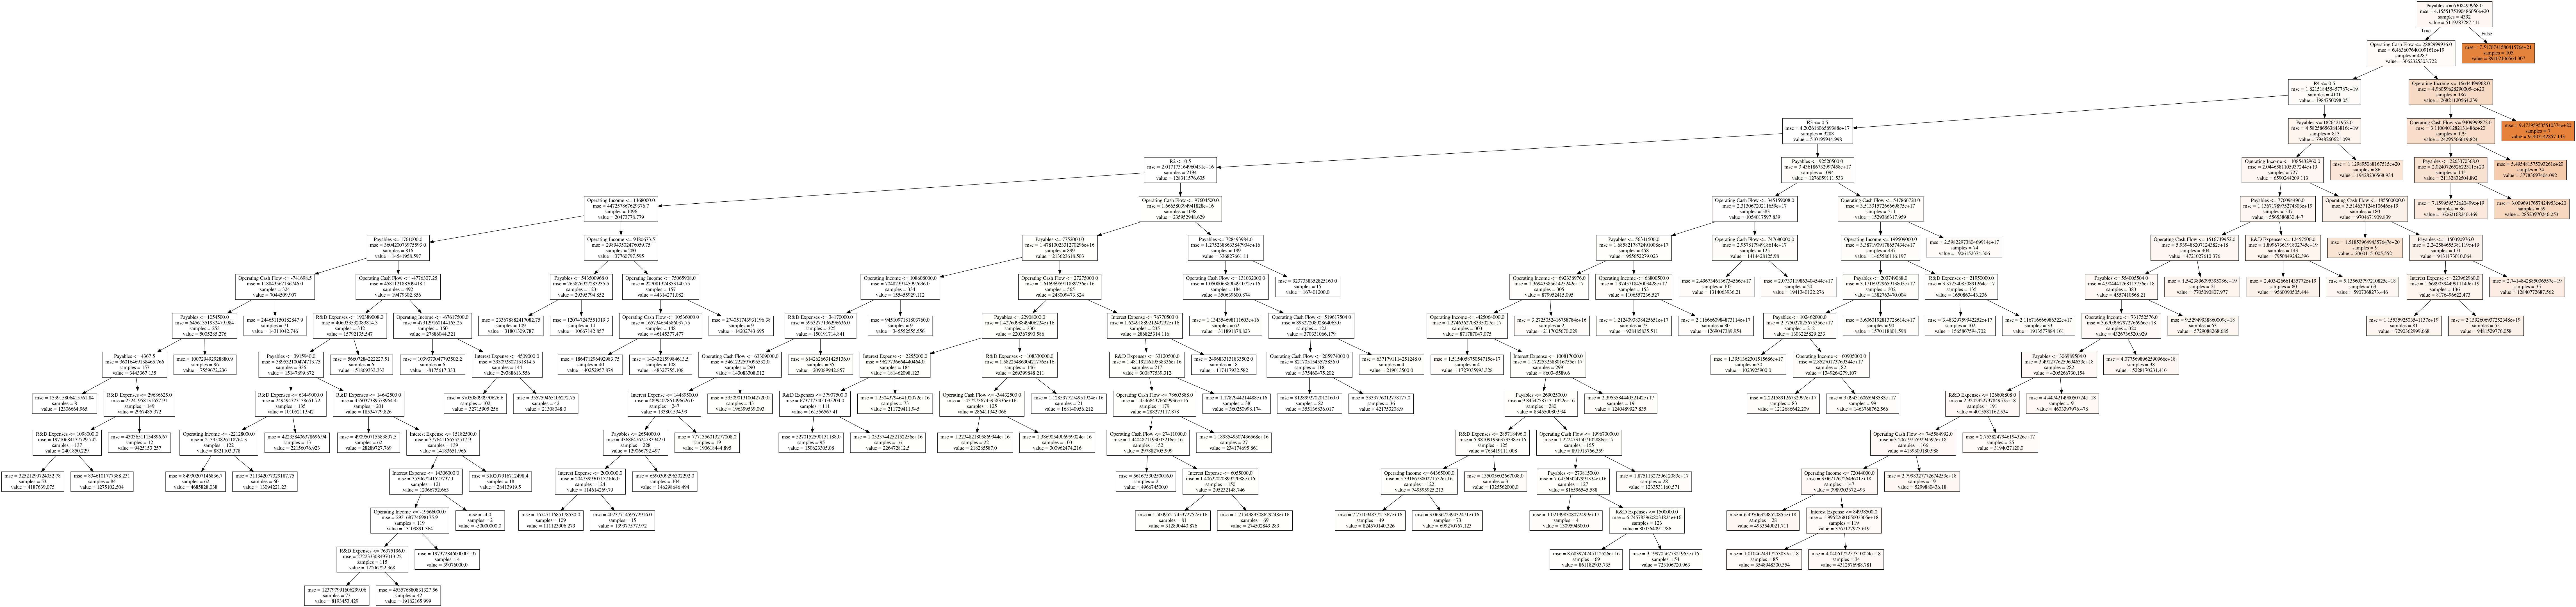

In [607]:


import pydotplus
import pydot
from IPython.display import Image

%matplotlib inline

# One big tree. Each node split will include at least 2.5% of the total sample.
decision_tree = tree.DecisionTreeRegressor(min_samples_split=.025)
y = Financial_df['Revenue']
decision_tree.fit(X,y)

# Get and store predicted values
pred = decision_tree.predict(X)
print('One strongish learner R^2: {}'.format(decision_tree.score(X, y)))

dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,  
                                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png()) 

In [608]:
import timeit
 
start = timeit.default_timer()
 
# Executed code here
 
stop = timeit.default_timer()
execution_time = stop - start
 
print("Program Executed in "+str(execution_time)) # It returns time in seconds

Program Executed in 2.4214998120442033e-05


In [613]:
#Setup Data into two dataframes:
targetdf = df['Revenuegroup']
featdf = df.drop(["Revenue","Weighted Average Shs Out", "Goodwill and Intangible Assets","Deferred revenue",
                       "Retained earnings (deficit)","Company Name","Sector","Revenuegroup","Long-term debt",
                      "Tax assets"], 1)

# This is the model that you'll be using
from sklearn import tree

# A convenience for displaying visualizations
from IPython.display import Image

# Packages for rendering the tree
import pydotplus
#import graphviz

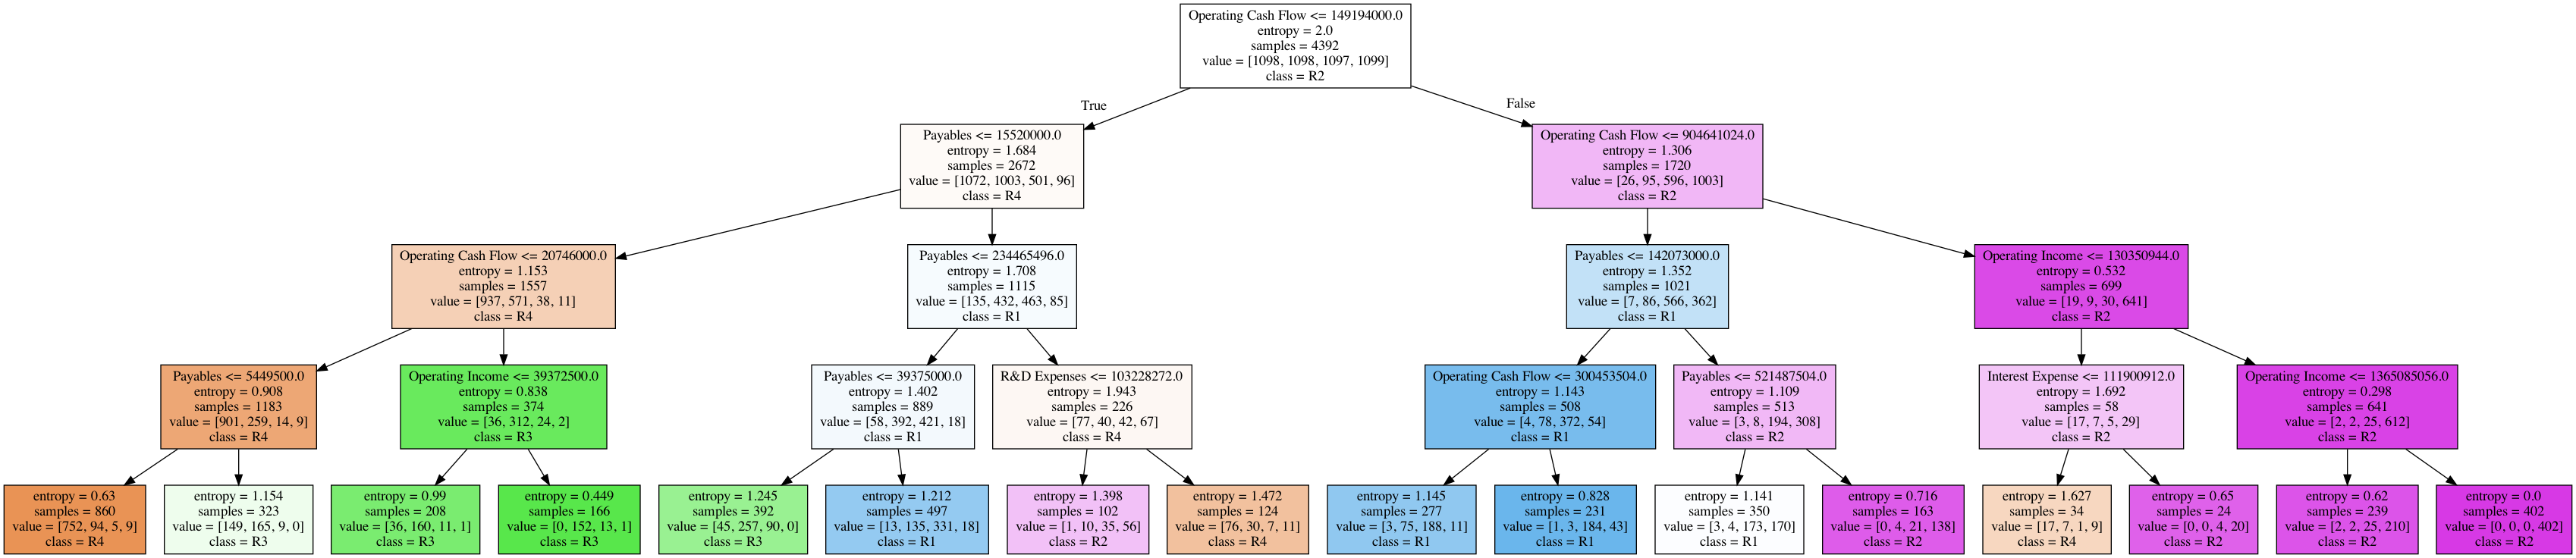

In [614]:
#this is to start the timer to measure execution time:
start = timeit.default_timer()

# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=1,
    max_depth=4,
    random_state = 42
)
decision_tree.fit(featdf, targetdf)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=featdf.columns,
    class_names=targetdf.unique(),
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)

#this is to stop the timer and to measure execution time:
stop = timeit.default_timer()
execution_time = stop - start

#Prints the image of tree:
Image(graph.create_png())

In [615]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Checkpoint start timer:
start = timeit.default_timer()
#Model creation
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, featdf, targetdf, cv=10))
 
#Stop timer and record time:
stop = timeit.default_timer()
execution_time = stop - start

[0.76590909 0.775      0.7904328  0.80637813 0.81776765 0.76309795
 0.80865604 0.7904328  0.73348519 0.71070615]
